In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import keras

import integrated_gradients as ig
import my_utils
from metaplot import Metaplot, one_hot_encode
from sklearn import preprocessing
from varname import nameof


def plot_meta(data, model, subset=None):

    if subset is None:
        print(len(data))
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        Metaplot(data_ig, colorbar = False)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)]
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        Metaplot(lowest_ten_ig, colorbar = False)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)]
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        Metaplot(highest_ten_ig, colorbar = False)
        
    else:
        raise ValueError()

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df

def outliers(df, order, typ, cut_fp=1.0, cut_fn=2.0):
    if order == 'collect':
        if typ == 'fp':
            out = df[(df['pred'] - df['rl']) >= cut_fp]
    
        elif typ == 'fn':
            out = df[(df['rl'] - df['pred']) >= cut_fn]

        else:
            raise ValueError()
    
    elif order == 'remove':
        if typ == 'fp':
            out = df[(df['pred'] - df['rl']) <= cut_fp]
        
        elif typ == 'fn':
            out = df[(df['rl'] - df['pred']) <= cut_fn]

    return out



    

In [25]:
#import data

#MRL on random
test_mrl_random = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/MRL_pred.csv')
#hMRL on human
test_hmrl_human = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/hMRL_human_50_test_pred.csv')
#MRL on human
test_hmrl_random = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/MRL_pred.csv').drop(['pred', 'Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

#hMRL on random
test_mrl_human = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/hMRL_human_50_test_pred.csv').drop(['pred', 'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2'], axis = 1)


#import models
mrl_model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/data/models/main_MRL_model.hdf5')
hmrl_model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/data/models/human_MRL_model.hdf5')

#make predictions
seq_test_mrl_human = one_hot_encode(test_mrl_human, 'utr', 50)
test_mrl_human = test_data(df=test_mrl_human, model=mrl_model,test_seq=seq_test_mrl_human, obs_col='rl', output_col='pred')

seq_test_hmrl_random = one_hot_encode(test_hmrl_random, 'utr', 50)
test_hmrl_random = test_data(df=test_hmrl_random, model=hmrl_model, test_seq=seq_test_hmrl_random, obs_col='rl', output_col='pred')




#Outliers

#dict_dfs = {}
#for x,f in [test_mrl_random, test_mrl_human, test_hmrl_random, test_hmrl_human],['fp', 'fn']:
#    key_name = f + '_' + nameof(x)
#    dict_dfs[key_name] = outliers(x, 'collect', f)

#    x = outliers(x, 'remove', f)
    
        


#FP
fp_test_mrl_random = outliers(test_mrl_random, 'collect', 'fp')
fp_test_mrl_human = outliers(test_mrl_human, 'collect', 'fp')
fp_test_hmrl_random = outliers(test_hmrl_random, 'collect', 'fp')
fp_test_hmrl_human = outliers(test_mrl_human, 'collect', 'fp')

#FN
fn_test_mrl_random = outliers(test_mrl_random, 'collect', 'fn')
fn_test_mrl_human = outliers(test_mrl_human, 'collect', 'fn')
fn_test_hmrl_random = outliers(test_hmrl_random, 'collect', 'fn')
fn_test_hmrl_human = outliers(test_mrl_human, 'collect', 'fn')



<font color=skyblue size=30> Meta-Attribution of 5'UTR Signals  </font>

(MRL->Random)

88


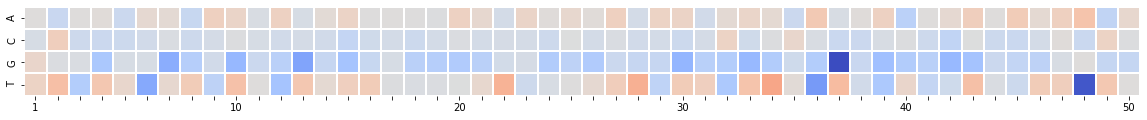

316


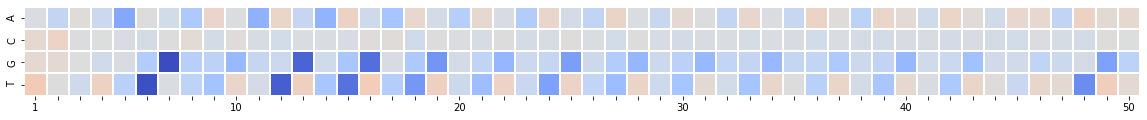

In [26]:
plot_meta(fp_test_mrl_random, mrl_model)
plot_meta(fn_test_mrl_random, mrl_model)

#plot_meta(test_random, mrl_model)
#plot_meta(test_random, mrl_model, subset='highest_ten')
#plot_meta(test_random, mrl_model, subset='lowest_ten')

(MRL->Human)

268


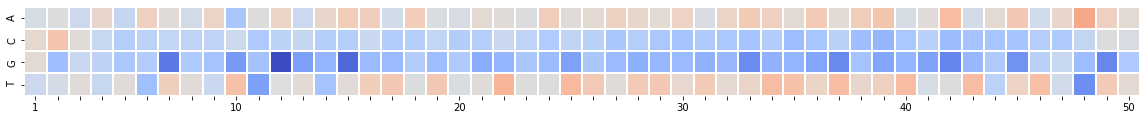

1


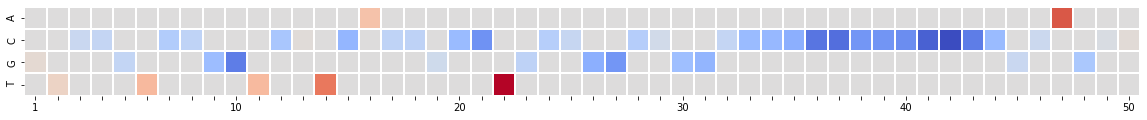

In [27]:
plot_meta(fp_test_mrl_human, mrl_model)
plot_meta(fn_test_mrl_human, mrl_model)

#plot_meta(test_human, mrl_model)
#plot_meta(test_human, mrl_model, subset='highest_ten')
#plot_meta(test_human, mrl_model, subset='lowest_ten')

(hMRL->Random)

538


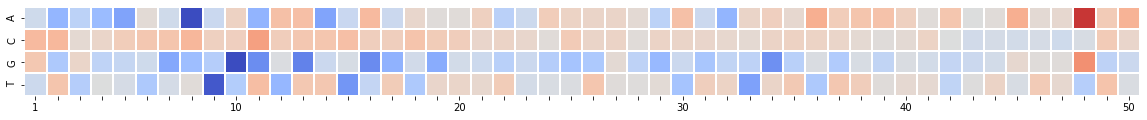

2705


In [28]:
plot_meta(fp_test_hmrl_random, hmrl_model)
plot_meta(fn_test_hmrl_random, hmrl_model)

#plot_meta(test_random, hmrl_model)
#plot_meta(test_random, hmrl_model, subset='highest_ten')
#plot_meta(test_random, hmrl_model, subset='lowest_ten')

(hMRL->Human)

320


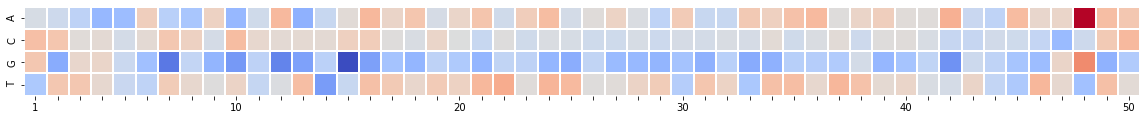

13


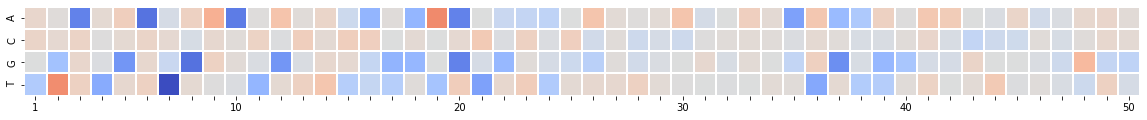

4667


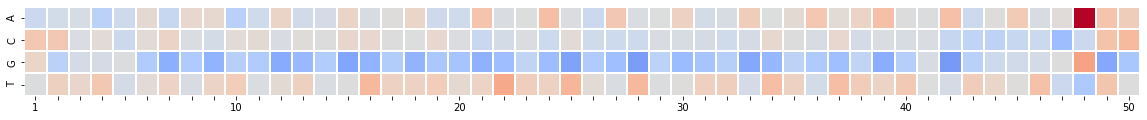

467


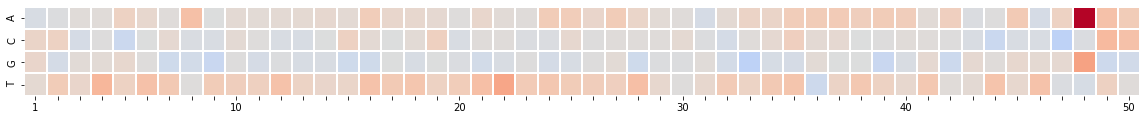

467


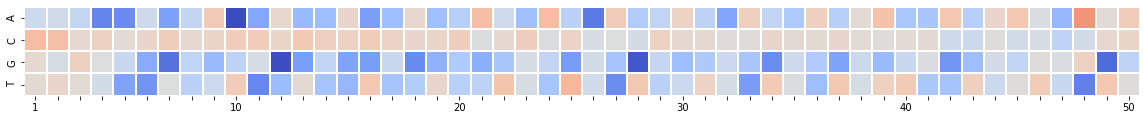

In [ ]:
plot_meta(fp_test_hmrl_human, hmrl_model)
plot_meta(fn_test_hmrl_human, hmrl_model)

#plot_meta(test_human, hmrl_model)
#plot_meta(test_human, hmrl_model, subset='highest_ten')
#plot_meta(test_human, hmrl_model, subset='lowest_ten')